# Introduction to the computional Theory of Mind (ToM) model

The following is an introduction to the computational implementation of Theory of Mind (ToM) originally presented by [Devaine et al. (2017)](http://dx.plos.org/10.1371/journal.pcbi.1005833), which is the model used by the ToM agents in the tomsup package. The guide will first give a conceptual overview of the model and its parameters, and will then go through the model in detail.

---
## Conceptual overview
The ToM model used here is an attempt at approximating the theory of mind processes in humans. The simplest kind of ToM agent - the 0-ToM - assumes that it's opponent chooses randomly with a specific probability. It then employs a variational bayes kalman filter to estimate that choice probability based on the opponent's behavior, and makes the choice that will give it the most value, given the opponent's choice probability. In this sense, the 0-TOM does not attribute any intentionality or adaptivity to the opponent, but treats the opponent's choices as randomly generated phenomena. Within the context of this module, this would correspond to assuming that the opponent is a random bias agent.

The more advanced 1-ToM, in turn, assumes that its opponent is a 0-ToM trying to predict the actions of the 1-ToM in the manner described above. The 1-TOM takes its opponent's perspective by simulating a 0-ToM model given the same inputs as the opponent. Based on this simulation of its opponent, and on an estimation of the opponent's model parameters, 1-ToM finally estimates the opponent's choice probability, and makes its own choice accordingly. An even more sophisticated 2-TOM agent, then, assumes its opponent to either be a 1-ToM or a 0-ToM. This means that, in order to predict it's opponent's move, 2-TOM must not only estimate the opponent's model parameters, but also estimate which model the opponent is using; that is, whether the opponent is a 0-TOM or a 1-TOM. 2-TOM does this on a turn by turn basis, by comparing the estimated choice probabilities to te opponent's actual behavior.

In general, then, the k-TOM agent with k>0 estimates beliefs and model parameter values for k simulated opponents with levels between 0 and k-1. Based on these belief and parameter estimates it determines a different choice probability for each possible opponent type. It is the average of these choice probabilities, weighted by the estimated probability that the opponent is of the given type, which is used as the final estimate of the opponent's choice probability. Importantly, because k-TOM must simulate an opponent who is also simulating its own opponent, and where this simulated opponent may also have its own simulation and so on, k-TOM agents with higher levels perform many layers of recursive estimation, which means they become computationally demanding.

k-TOM has the following model parameters: its sophistication level k, its volatility $\sigma$, its behavioral temperature $\beta$, its bias b and its dilution d. The sophistication level is described above. The volatility denotes how much k-TOM expects its opponent's parameters to drift, putting a lower bound on the uncertainty of its parameters estimates. The behavioral temperature decides to which degree, given an estimated choice proability for the opponent, k-TOM will randomize its behavior. The bias simply denotes an a priori preference for choosing one option or the other. And the dilution parameter decides to which degree k-TOM reduces its certainties in its estimations of the opponent's sophistication level, which allows it to re-estimate the level of an opponent who switches strategy during the game. 

The sophistication level can be any whole non-negative number, although sophistication levels above 5 are usually too computationally demanding to be practical. The volatility is inputted on a log scale, with lower numbers meaning less assumed volatility of opponent parameters. As default it is set to -2. The behavioral temperature is also inputted on a log scale, with lower numbers meaning less randomized behavior. It is as default set to -1. 
Bias can be any positive or negative number, with negative numbers indicating a preference for option 0, while positive numbers indicate a preference for option 1. dilution can be any number between 0 and 1, where 0 means no forgetting, and 1 means complete resetting of estimated probabilites of opponent levels every turn. Note that while both bias and dilution have no direct effect on k-TOM's behavior if set to 0, it still estimates them for the opponent. If they are set to "None", they will not be estimated for the opponent. As default, bias is set to 0, because it is necessary for k-TOM to predict the behavior of random bias opponents, and dilution is set to "None".

k-TOM uses a variational Bayes Laplace approximation (for more on this, see chapter 5 in [this book](https://bookdown.org/rdpeng/advstatcomp/laplace-approximation.html)) to estimate opponent parameter values. This means that every parameter estimate is represented with a mean and a variance. The estimate of the opponent's choice probability is represented with a mean, produced by simulating the opponent's choice alorithm using the means of the estimated parameters, and a variance, which is a composite of the variances of all parameter estimates. The estimated probability of the opponent having a certain sophistication level is represented with a simple probability.
 In the end of this tutorial, after the practical examples for the k-TOM agent, there is a more thorough explanation of the mathematics behind the k-TOM model. But now we will move the in-code implementation of the k-TOM agent.


---
# Application and code

In the following, we will show how to program a k-TOM agent, how to set its model parameters, how to make it compete, and how to extract its estimates at a given time.

First we create some different TOM agents. We set their volatilities behavioral temperatures. Notice that if bias or dilution is set to 0, they do not affect the k-TOM's own behavior, but k-TOM still estimates them for its opponent. If they are set to "None", they are also not estimated for the opponent. 

We set all k-TOM agents to save their history, which will later allows us to extract their estimates on any given round.

In [1]:
#This is only relevant if tomsup was installed from the github folder
#Move up to the correct folder
import os
os.chdir('..')
#And import the tomsup library
import tomsup as ts

#Get the competitive penny game payoff matrix
penny = ts.PayoffMatrix("penny_competitive")

In [2]:
#Create a 0-TOM agent with volatility -2, temperature -1, and no bias or dilution.
sir_TOM0 = ts.TOM(level = 0, volatility= -2,  b_temp= -1, bias = None, dilution = None, save_history = True)

#Create a 1-TOM agent with a higher volatility 1, temperature -1, no bias or dilution, but which estimates the bias of its opponent.
sir_TOM1 = ts.TOM(level = 1, volatility= 1,  b_temp= -1, bias = 0, dilution = None, save_history = True)

#Create a 2-TOM agent with default values: volatility -2, temperature -1, no bias or dilution, but which estimates the bias of its opponent.
sir_TOM2 = ts.TOM(level = 2, volatility= -2,  b_temp= -1, bias = 0, dilution = None, save_history = True)

#Create a 2-TOM agent with volatility -2, a low temperature -4, a bias of 0.5 and a dilution of 0.4.
sir_TOM2_d = ts.TOM(level = 2, volatility= -2,  b_temp= -4, bias = 0.5, dilution = 0.4, save_history = True)

In [3]:
#We can extract the given parameter values of the agents
print(sir_TOM0.get_parameters())
print(sir_TOM2.get_parameters())
print(sir_TOM2_d.get_parameters())

{'volatility': -2, 'b_temp': -1}
{'volatility': -2, 'b_temp': -1, 'bias': 0}
{'volatility': -2, 'b_temp': -4, 'dilution': 0.4, 'bias': 0.5}


In [4]:
#Make the 0-TOM agent compete a number of rounds while saving its history. It automatically updates its beliefs based on the op_choice behavior we input.
sir_TOM0.compete(p_matrix = penny, agent = 0, op_choice=None, save_history = True)
sir_TOM0.compete(p_matrix = penny, agent = 0, op_choice=1, save_history= True)
sir_TOM0.compete(p_matrix = penny, agent = 0, op_choice=1, save_history = True)

1

We can see 0-TOM's estimates of its opponent as they were on the latest round. The dictionary "own_states" contains 0-TOM's estimates of its opponent. p_op_mean0 is the estimated mean choice probability of the opponent, p_op_var0 is the variance of that estimate, and p_self is 0-TOM's own choice probability. The dictionary "opponent_states" contains the simulated estimates of the opponent; it is empty because there is no recursive belief simulation in the 0-TOM model.

In [5]:
print(sir_TOM0.get_internal_states())

print("---")

#There is also a print function which can give a better overview of the internal states
sir_TOM0.print_internal()

{'opponent_states': {}, 'own_states': {'p_op_mean0': 0.7631368312390914, 'p_op_var0': -0.1979324771056322, 'p_self': 0.8528708712402868, 'p_op': 0.6616184089945613}}
---
opponent_states
own_states
|   p_op_mean0:  0.7631368312390914
|   p_op_var0:   -0.1979324771056322
|   p_self:      0.8528708712402868
|   p_op:        0.6616184089945613


We can also get the internal states of 0-TOM on all the trials it has partaken in. They come out as a pandas dataframe, with the agents choice  and internal states for each round

In [6]:
print(sir_TOM0.get_history())

choice                                    internal_states
0       0  {'opponent_states': {}, 'own_states': {'p_op_m...
1       1  {'opponent_states': {}, 'own_states': {'p_op_m...
2       1  {'opponent_states': {}, 'own_states': {'p_op_m...


We now make the 1-TOM agent compete in order to look at its internal states


In [7]:
sir_TOM1.compete(p_matrix = penny, agent = 0, op_choice=None, save_history = True)
sir_TOM1.compete(p_matrix = penny, agent = 0, op_choice=1, save_history= True)
sir_TOM1.compete(p_matrix = penny, agent = 0, op_choice=1, save_history = True)

0

We can print its internal states - which includes 1-TOM's estimates of its opponent, but also its simulated opponents estimates of 1-TOM itself. Inside the "opponent_states" part is found the internal states of the simulated 0-TOM, which have the same structure as the 0-TOM agent from before. In the "own_states" section, we can now see all of 1-TOM's estimates. p_k is the probability of the opponent having a specific level; it is one because 1-TOM only simulates one level. The p_op_mean is the mean estimate of the opponent's choice probability. The param_mean and the param_var hold the means and variances, respectively, of the estimates of each of the opponent's parameters. The order of the numbers is always the estimate of the temoerature, the volatility, the bias and the dilution, excluding those that were set as "None" in the beginning. The gradient is a measure of the size of the influence on variations in the parameter estimates on the simulated opponent's behavior - this is explained more in the last section. And finally, the p_self is 1-TOM's own choice probability.

In [8]:
sir_TOM1.print_internal()

opponent_states
|   0-ToM
|   |   opponent_states
|   |   own_states
|   |   |   p_op_mean0:  1.1280643859125716
|   |   |   p_op_var0:   0.30754188435524904
own_states
|   p_k:         [1.0]
|   p_op_mean:   [0.0943228356528689]
|   param_mean:  [[-0.47280546912242205, 0.2663542787845688, 0.7560148396074139]]
|   param_var:   [[1.8301571538130683, -0.06872456555769926, -0.404711292625637]]
|   gradient:    [[-0.031212057683971395, 0.6616589189371858, 0.999999997988027]]
|   p_self:      0.5541357132864706
|   p_op:        0.5199937888470717


Again, we can get the internal states on every trial with the get_history command. This is useful for when the internal states are to be analyzed.

In [9]:
print(sir_TOM1.get_history())

choice                                    internal_states
0       1  {'opponent_states': {0: {'opponent_states': {}...
1       1  {'opponent_states': {0: {'opponent_states': {}...
2       0  {'opponent_states': {0: {'opponent_states': {}...


There are also pre-made functions for plotting the internal states of the 1-TOM.

In [10]:
###PRINT FUNCTIONS###

We now make a 2-TOM with all parameters enabled compete, to show how its structure looks

In [11]:
sir_TOM2_d.compete(p_matrix = penny, agent = 0, op_choice=None, save_history = True)
sir_TOM2_d.compete(p_matrix = penny, agent = 0, op_choice=1, save_history= True)
sir_TOM2_d.compete(p_matrix = penny, agent = 0, op_choice=1, save_history = True)

1

We print its internal states. The structure here is similar, except that 2-TOM simluates both a 0-TOM, for which the estimated internal states are shown first, and a 1-TOM, which has its own simulated 0-TOM opponent. We also see that in the 2-TOM's own states, there are two sophistication levels p_k. There are also a p_op_mean, and a vector of parameter estimate mean and variances, now with four numbers because all four parameters are included, for each for the two simulated opponent levels. For higher levels these numbers of values and vectors increase accordingly.

In [12]:
sir_TOM2_d.print_internal()

opponent_states
|   0-ToM
|   |   opponent_states
|   |   own_states
|   |   |   p_op_mean0:  -0.33018140088126746
|   |   |   p_op_var0:   0.41121317680723385
|   1-ToM
|   |   opponent_states
|   |   |   0-ToM
|   |   |   |   opponent_states
|   |   |   |   own_states
|   |   |   |   |   p_op_mean0:  1.146700695352714
|   |   |   |   |   p_op_var0:   0.3471384760097934
|   |   own_states
|   |   |   p_k:         [1.0]
|   |   |   p_op_mean:   [0.5115875013538752]
|   |   |   param_mean:  [[-0.3024702399093408, 0.36289311428598925, 0.0, -0.09434866723123012]]
|   |   |   param_var:   [[1.0866362764594433, -0.05626325940758126, 0.0, -0.3732623811410634]]
|   |   |   gradient:    [[0.0320135865561344, -0.6059058724838806, 0.0, 0.9999999977317042]]
own_states
|   p_k:         [0.5321896191205729, 0.46781038087942706]
|   p_op_mean:   [0.6926645809654387, 0.1116140560825793]
|   param_mean:  [[-0.05531198238276957, 0.15843582464960362, 0.0, 0.4671370572156244], [0.00065523166484912, 0.207

We can of course also for 2-TOMs get the internal states for every round

In [13]:
print(sir_TOM2_d.get_history())

choice                                    internal_states
0       1  {'opponent_states': {0: {'opponent_states': {}...
1       0  {'opponent_states': {0: {'opponent_states': {}...
2       1  {'opponent_states': {0: {'opponent_states': {}...


Here it is also possible to use the premade plot functions

In [14]:
###PLOT FUNCTION

Finally, we can of course make a group of TOM agents and have them compete against each other.

In [37]:
# Create list of agents
#all_agents = ['RB', '0-TOM', '1-TOM', '2-TOM', 'WSLS']
# And set their params. Note that unspecified parameters values simply are set as the default values.
#all_params = [{'bias': 0.8}, {'volatility': -2, 'b_temp': -1}, {}, {}, {}]

all_agents = ['1-TOM', '2-TOM']
# And set their params. Note that unspecified parameters values simply are set as the default values.
all_params = [{}, {}]

# We add the save_history to all parameter sets, in order to make sure we can get the internal states of all agents
for d in all_params:
    d['save_history'] = True

# Now we create the group and set the tournament environment
group = ts.AgentGroup(all_agents, all_params)

group.set_env(env='round_robin')

# Finally, we make the group compete 20 simulations of 30 rounds
group.compete(p_matrix = penny, n_rounds = 50, n_sim = 20, save_history = True)

Currently the pair, ('1-TOM', '2-TOM'), is competing for 20                         simulations, each containg 50 rounds.
	Running simulation 1 out of 20
	Running simulation 2 out of 20
	Running simulation 3 out of 20
	Running simulation 4 out of 20
	Running simulation 5 out of 20
	Running simulation 6 out of 20
	Running simulation 7 out of 20
	Running simulation 8 out of 20
	Running simulation 9 out of 20
	Running simulation 10 out of 20
	Running simulation 11 out of 20
	Running simulation 12 out of 20
	Running simulation 13 out of 20
	Running simulation 14 out of 20
	Running simulation 15 out of 20
	Running simulation 16 out of 20
	Running simulation 17 out of 20
	Running simulation 18 out of 20
	Running simulation 19 out of 20
	Running simulation 20 out of 20
Simulation complete


In [30]:
# explore results
group.head(5)

,n_sim,round,choice_agent0,choice_agent1,payoff_agent0,payoff_agent1,history_agent0,history_agent1,agent0,agent1
0,0,0,1,0,-1,1,"{'choice': 1, 'internal_states': {'opponent_st...","{'choice': 0, 'internal_states': {'opponent_st...",4-TOM,5-TOM
1,0,1,0,0,1,-1,"{'choice': 0, 'internal_states': {'opponent_st...","{'choice': 0, 'internal_states': {'opponent_st...",4-TOM,5-TOM
2,0,2,0,0,1,-1,"{'choice': 0, 'internal_states': {'opponent_st...","{'choice': 0, 'internal_states': {'opponent_st...",4-TOM,5-TOM
3,0,3,1,1,1,-1,"{'choice': 1, 'internal_states': {'opponent_st...","{'choice': 1, 'internal_states': {'opponent_st...",4-TOM,5-TOM
4,0,4,1,0,-1,1,"{'choice': 1, 'internal_states': {'opponent_st...","{'choice': 0, 'internal_states': {'opponent_st...",4-TOM,5-TOM


In [31]:
group.pairing  # examine groups for plotting

[('4-TOM', '5-TOM')]

history_agent1 1


<Figure size 432x288 with 0 Axes>

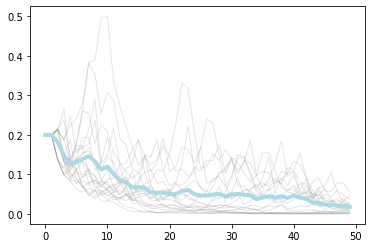

history_agent1 1


<Figure size 432x288 with 0 Axes>

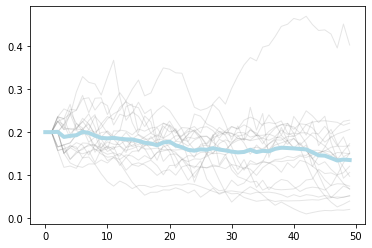

history_agent1 1


<Figure size 432x288 with 0 Axes>

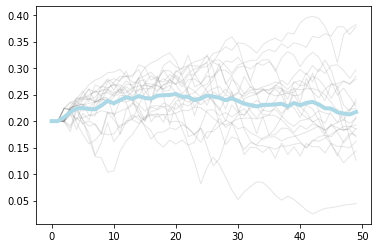

history_agent1 1


<Figure size 432x288 with 0 Axes>

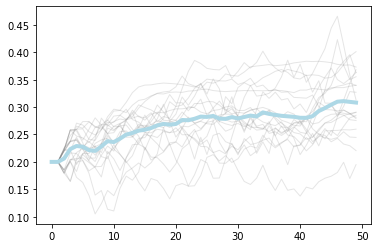

history_agent1 1


<Figure size 432x288 with 0 Axes>

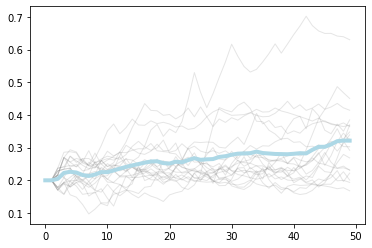

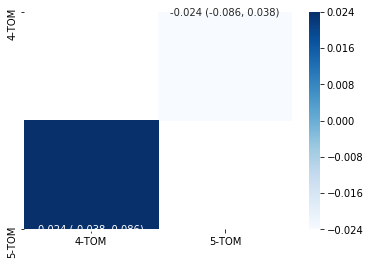

In [35]:
#group.plot_p_k(agent0='1-TOM', agent1='2-TOM', agent=1, k=0) # agent 1 to see it from 2-ToM's perspective
#group.plot_p_k(agent0='1-TOM', agent1='2-TOM', agent=1, k=1) 
#group.plot_p_k(agent0='2-TOM', agent1='WSLS', agent=0, k=0)
#group.plot_heatmap()
group.plot_p_k(agent0='4-TOM', agent1='5-TOM', agent=1, k=0)
group.plot_p_k(agent0='4-TOM', agent1='5-TOM', agent=1, k=1)
group.plot_p_k(agent0='4-TOM', agent1='5-TOM', agent=1, k=2)
group.plot_p_k(agent0='4-TOM', agent1='5-TOM', agent=1, k=3)
group.plot_p_k(agent0='4-TOM', agent1='5-TOM', agent=1, k=4)


group.plot_heatmap()

history_agent0 0


<Figure size 432x288 with 0 Axes>

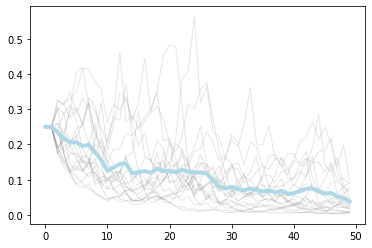

history_agent0 0


<Figure size 432x288 with 0 Axes>

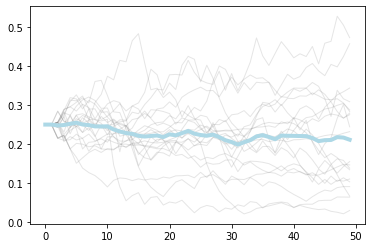

history_agent0 0


<Figure size 432x288 with 0 Axes>

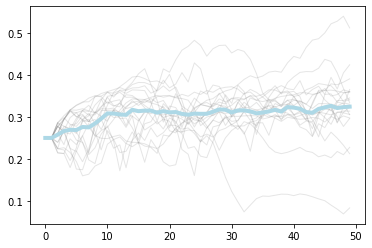

history_agent0 0


<Figure size 432x288 with 0 Axes>

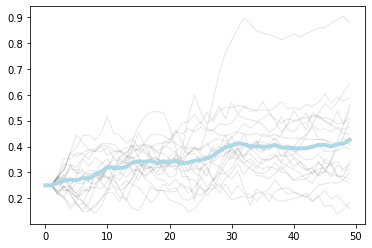

In [36]:
group.plot_p_k(agent0='4-TOM', agent1='5-TOM', agent=0, k=0)
group.plot_p_k(agent0='4-TOM', agent1='5-TOM', agent=0, k=1)
group.plot_p_k(agent0='4-TOM', agent1='5-TOM', agent=0, k=2)
group.plot_p_k(agent0='4-TOM', agent1='5-TOM', agent=0, k=3)


history_agent1 1


<Figure size 432x288 with 0 Axes>

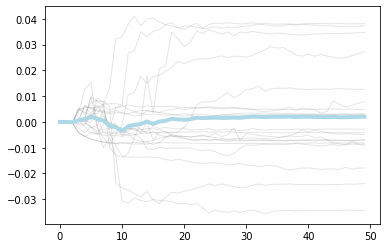

history_agent1 1


<Figure size 432x288 with 0 Axes>

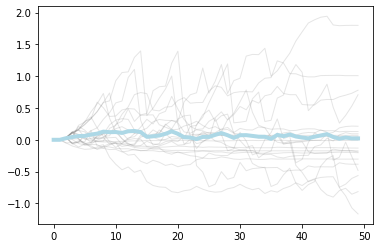

history_agent1 1


<Figure size 432x288 with 0 Axes>

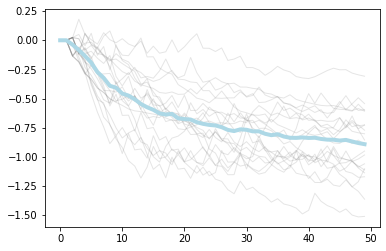

history_agent1 1


<Figure size 432x288 with 0 Axes>

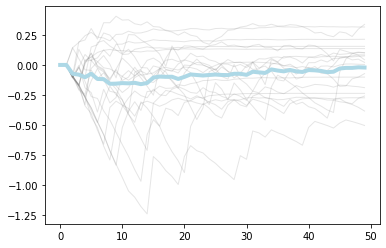

history_agent1 1


<Figure size 432x288 with 0 Axes>

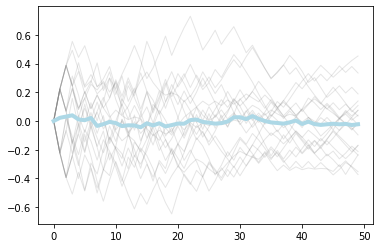

history_agent1 1


<Figure size 432x288 with 0 Axes>

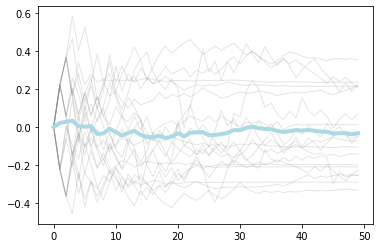

In [53]:
group.plot_history("1-TOM", "2-TOM", agent=1, state="", fun=lambda x: x['internal_states']['own_states']['param_mean'][1,0])
group.plot_history("1-TOM", "2-TOM", agent=1, state="", fun=lambda x: x['internal_states']['own_states']['param_mean'][0,0])

group.plot_history("1-TOM", "2-TOM", agent=1, state="", fun=lambda x: x['internal_states']['own_states']['param_mean'][1,1])
group.plot_history("1-TOM", "2-TOM", agent=1, state="", fun=lambda x: x['internal_states']['own_states']['param_mean'][0,1])


group.plot_history("1-TOM", "2-TOM", agent=1, state="", fun=lambda x: x['internal_states']['own_states']['param_mean'][1,2])
group.plot_history("1-TOM", "2-TOM", agent=1, state="", fun=lambda x: x['internal_states']['own_states']['param_mean'][0,2])

# Mathematical description: the k-TOM model

Following the conceptual introduction we will go further into how the mathematical underpinnings of the ToM agent. We will start of with an introduction to the decision process and then examine the learning process. The learning processing will start of by introducing the 0-ToM and then generalize to the k-ToM agent. The following overview should give an idea of what we are going to go through:


<img src="img/overview.png" alt="Overview of k-ToM" style="width: 500px;"/>

In [ ]:
# #if if is not read above it should be read using this code:
# from IPython.display import Image # for loading in images
# Image("tutorials/img/overview.png")

## The Decision Process

After the learning process, which we will leave be for now, we will have estimated the probability ${P}^{op}_{t}$ of the opponent choosing 1. 

Now, as the first step in k-ToM's decision process, ${P}^{op}_{t}$ is inserted into the expected payoff function, shown below:

$$
\begin{equation}
\Delta V_t = {p}^{op}_{t} (U(1,1) - U(0, 1)) + (1-{p}^{op}_{t}) (U(1,0) - U(0,0))
\end{equation}\tag{1}
$$

Where $\Delta V_t$ is k-ToM's expected payoff of choosing 1 relative to 0 on the trial $t$. The notation $U({c}^{self},{c}^{op})$ denotes the payoff (utility) function, which returns the reward $R$ given a payoff matrix and the (hypothetical) choices of 0-ToM agent ${c}^{self}$ and the opponent ${c}^{op}$. This equation essentially finds the payoff difference of choosing 1 relative to 0 given both possible opponent choices, and sums them weighted by the probability of the opponent making that choice.

To calculate 0-ToM's own probability of choosing 1, 0-ToM's expected payoff of choosing 1, $\Delta V_t$ ,is now inserted in the softmax decision rule, as shown below:

$$
\begin{equation}
P({ c }^{ self }_t = 1)= \frac { 1 }{ 1 + exp(-\frac { \Delta V_t }{ \beta} ) }
\end{equation}\tag{2}
$$


Where $P({c}^{self}_t=1)$ is 0-ToM's probability of choosing 1 on the current trial $t$. $\beta$ then denotes 0-ToM’s behavioural temperature parameter, which randomizes behaviour. An expected payoff of 0, i.e. equal values of choosing 1 or 0, results in a random choice, $P({c}^{self}_t=1)=0.5$ . Higher expected values then result in higher probabilities of choosing 1 (in a sigmoidal manner asymptotic to 1 and 0). Higher $\beta$ values restrict choice probabilities closer to 0.5, i.e. increases exploration. The softmax choice rule has previously proven efficient in game theory and in modelling choices on tasks such as the Iowa gambling task, as it provides a good balance between exploitation and exploration (Camerer, 2003; Steingroever et al., 2013).

Now that $P({c}^{self}_t=1)$ has been calculated, 0-ToM's decision process is concluded. All that follows is for the probability to be evaluated so 0-ToM can make its choice, after which the next trial commences.

This will leave the decision model as follows:


<img src="img/overview_dp.png" alt="Expanded overview of k-ToM" style="width: 500px;"/>



## Learning Process
### The 0-ToM
All ToM agents estimate their opponents’ parameter values $\theta$ in order to learn the choice probability of their opponents $P_t^{op}$, but since 0-ToM assumes its opponent to use a random phenoma, the estimation of the probability parameter and the choice probability $P_t^{op}$ becomes identical. The choice probability parameter is estimated as a normal distribution with mean $\mu$ and variance $\Sigma$, each of which are updated on a turn-by turn-basis, based on the opponent’s last choice. This is done using a a variational Bayes Laplace approximation (for more on this, see chapter 5 in [this book](https://bookdown.org/rdpeng/advstatcomp/laplace-approximation.html)) for parameters with a linear relation to observed behaviour. In the graphical model (see following figure), 0-ToM’s learning and decision process can be seen. First the variance $\Sigma$ is updated, then the mean estimate $\mu$. This allows the estimation of the opponent’s choice probability $P_t^{op}$, after which the expected payoff difference $\Delta V$ can be calculated and inserted in the softmax function to decide 0-ToM’s own choice probability $P(c^{self} = 1)$.

<img src="img/gm_tom_0.png" alt="Graphical Models of 0-ToM" style="width: 500px;"/>

### Variance update
The variance $\Sigma$ is updated using the following equation:

$$
\begin{equation}
{ \Sigma  }_{ t }^{ 0 }\quad \approx \quad \frac { 1 }{ \frac { 1 }{ { \Sigma  }_{ t-1 }^{ 0 }+{ \sigma  }^{ 0 } } \quad +\quad s({ { \mu  } }_{ t-1 }^{ 0 })(1-s({ { \mu  } }_{ t-1 }^{ 0 })) } 
\end{equation} \tag{3}
$$


Where ${ \mu}_{t}^{0}$ denotes 0-ToM’s mean estimate in logodds at trial $t$ of the opponent’s probability parameter $p$, and ${ \Sigma}_{t}^{0}$ denotes the subjective uncertainty of the parameter estimate at trial $t$, and where $t-1$ indicates the previous turn. $s$ is the sigmoid function, and the expression $s(\mu)$ is 0-ToM’s estimate in probability of opponent's choice probability $P^{op}_t$, without taking uncertainty $\Sigma$ into account. Note that a $\mu$ close to chance level results in a lower updated variance $\Sigma$. ${\sigma}^{0}$ denotes 0-ToM’s volatility parameter, which captures her prior assumptions on how much the opponent's parameters varies with time. (See Mathys et al., 2011) for a model where $\sigma$ is learned instead of assumed). The volatility parameter $\sigma$ controls the updating of variance $\Sigma$, where a higher volatility results in a higher updated variance on every trial. Together, the size of $\sigma$ and $\mu$ creates a dynamic lower bound for variance $\Sigma$.

### Mean update
After $\Sigma$ has been updated, it is used for updating the mean estimate $\mu$ of the opponent's choice probability parameter $p$ by insertion into the following equation:

$$
\begin{equation}
{ { \mu  } }_{ t }^{ 0 }\quad \approx \quad {  \mu   }^{0}_{ t-1 }\quad +\quad { \Sigma  }_{ t }^{ 0 }({ c }_{ t-1 }^{ op }\quad -\quad s({ { \mu  } }^{0}_{ t-1 }))\quad 
\end{equation} \tag{4}
$$

Where ${c}^{op}_{t}$ denotes the opponent’s choice at trial $t$. Consequently, the term ${c}^{op}_{t-1}-s({\mu}^{0}_{t-1})$ becomes the prediction error on last trial, which is added to the previous mean to update it. It is weighted by the variance $\Sigma$, meaning that very uncertain beliefs are affected more by new data than very certain ones. 

### Probability of opponent choosing 1
After having updated the mean and variance of the estimate of the opponent’s choice probability, 0-ToM uses the following equation to make its estimate the opponent of choosing 1 $P({c}^{op}=1)$:

$$
\begin{equation}
{  p   }_{ t }^{ op }\approx s\left( \frac { \mu _{ t }^{ 0 } }{ \sqrt { 1+(\Sigma ^{ 0 }_{ t }+\sigma ^{ 0 })3/\pi ^{ 2 } }  }  \right) 
\end{equation} \tag{5a} 
$$

Where ${P}^{op}_{t}$ is the estimated probability of the opponent choosing 1. Note that higher variance $\Sigma$ and volatility $\sigma$ values result in the choice probability estimates ${P}^{op}_{t}$ closer to chance level. This means that high subjective uncertainty and assuming more noise in the opponent's behaviour makes 0-ToM's estimates of its opponent's choice probability less extreme, and thus 0-ToM’s own choices more random, hereby preventing overfitting. 

Importantly, while equation 5a is the theoretically derived equation (Devaine et al., 2017), the implementation used in the VBA package (Daunizeau et al., 2014} uses an approximation to avoid identifiability issues:

$$
\begin{equation}
{  p   }_{ t }^{ op }\approx s\left( \frac { \mu _{ t }^{ 0 } }{ \sqrt { 1+a\cdot \Sigma ^{ 0 }_{ t } }  }  \right) 
\end{equation} \tag{5b} 
$$	

Where, a=0.36 is an approximation which contains within it the volatility parameter $\sigma$. This means that the volatility parameter $\sigma$ is held constant. Note that small uncertainties result in estimates of opponent choice probabilities ${P}^{op}_{t}$ closer to the mean $\mu$, i.e. $ \Sigma \rightarrow 0 \Rightarrow P^{op}_t\rightarrow \mu$. 

The two equations 5a and 5b give similar results when $\sigma$ values are below 1. This means that large volatility values do not affect the choice probability estimate directly, but only through equation 4. In initial simulations, using eq. 6a has a tendency to yield extreme parameter estimates because of identifiability issues, especially in the more complex $k$-ToM model.

The tomsup package is able to use both variants, but similarly to the VBA implementation (Daunizeau et al., 2014), it defaults to using eq. 6b, since it gives better performance and more stable results.

**KCE: peter skal vi lige vurdere om vi skal forkorte det sidste?**

## *k*-ToM

The learning process of $k$-ToM with $k>0$ differs from that of 0-ToM mainly in that $k$-ToM must simulate its opponent's learning and decision processes, in order to learn the opponent's choice probability ${P}^{op}_{t}$. To do this, $k$-ToM assumes its opponent to also be a ToM agent of a lower sophistication level $\kappa < k$. It must then estimate the opponent's parameter values $\theta$, which includes a behavioural temperature $\beta$ and a volatility $\sigma$. This is also done using a variational Bayes Laplace approximation, similar to 0-ToM's learning of RB's probability parameter, but since the parameters $\theta$ of a ToM agent has a nonlinear relation to the observed behaviour, linearity is no longer assumed, and the Laplace approximation gets more complex. The nonlinear variational Bayes Laplace approximation estimates parameter values as a normal distribution with a mean $\mu^{\theta}$ and variance $\Sigma^{\theta}$, for each of the opponent's parameters $\theta$. $k$-ToM then simulates its opponent's learning and decision process to calculate a mean estimate of the opponent's choice probability. This mean is also denoted $\mu$, but is distinct from $\mu^{\theta}$ by not being an estimation of a parameter, but of the opponent's behaviour. Because different behaviour is expected given different opponent levels $\kappa$, $k$-ToM makes parameter estimates $\mu^{\theta}$
and choice probability estimates $\mu$ for each of the opponent's possible levels $\kappa$. But since the opponent's sophistication level $\kappa$ is not known, $k$-ToM must first estimate the probability $\lambda$ for the opponent having each of the possible levels $\kappa < k$. 

In the following graphical model, $k$-ToM's learning and decision process can be seen. First the probability $\lambda$ of the opponent having each possible level $\kappa$ is updated. Then the variances $\Sigma^{\theta}$ and means $\mu^{\theta}$ of the parameter estimates are updated. Using the estimated parameter values, $k$-ToM performs a recursive simulation of its opponent to calculate a mean choice probability estimate $\mu$, which it compares to choice probability estimates using incremented parameter estimates in order to calculate the new gradient $W$. Now the choice probability for each possible opponent level $\kappa$, $P^{op, \kappa }$, can be calculated and averaged to a single choice probability estimate $P^{op}$. This is used to calculate the expected payoff $\Delta V$, which is inserted into the softmax function to calculate $k$-ToM's own choice probability $P(c^{self}=1)$.

**KCE: Peter vi skal lige kigge på denne graphical model sammen**

<img src="img/insert_me.png" alt="insert g.m. for ktom" style="width: 500px;"/>

For 1-ToM, calculating $\lambda$ is trivial, as there is only one option, as $P(\kappa =0)\equiv 1$. But $k$-ToM agents with $k>1$ must estimate $\lambda$ by comparing the expected behaviour of the opponent, given each level, to the actual behaviour. This is done by using the following equation:

$$
\begin{equation}
\lambda^{k,\kappa}_{t} \approx
\left(
\frac{\lambda^{k, \kappa}_{t-1} \quad P^{op, \kappa}_{t-1}}
{\sum_{\kappa' < k}{\lambda^{k, \kappa'}_{t-1} \quad P^{op, \kappa '}_{t-1}}}
\right)^{c^{op}_{t-1}} 
\left(  
\frac{\lambda^{k, \kappa}_{t-1} \quad (1-P^{op, \kappa}_{t-1})}
{\sum_{\kappa' < k}{\lambda^{k, \kappa'}_{t-1} \quad (1-P^{op, \kappa '}_{t-1})}}
\right)^{1-c^{op}_{t-1}} 
\end{equation}
\tag{6a}
$$
Where ${\lambda}^{k, \kappa }_{t}$ denotes $k$-ToM’s estimated probability $\lambda$ at trial $t$ of its opponent having the sophistication level $\kappa$, and ${p}^{op, \kappa}_{t-1}$ denotes the probability of opponent choosing 1, for each simulated level $\kappa$, on the previous trial. This equation updates the probability $\lambda$ for each $\kappa$ relative to the probability of the actual outcome that was estimated for that level. Thus, levels with incorrect predictions about the opponent’s choices become less probable over time. Dividing each calculated probability with the sum over levels $\kappa$ ensures that the probabilities $\lambda$ always sums to 1. Note that the exponentiation of the opponent’s choice $c^{op}_{t-1}$ decides by which choice (1 or 0) $\lambda$ should be updated, e.g. if the opponent chose 1, $\lambda$ is updated according to the first term. Furthermore, note that $\lambda$ is updated relative to itself, which means that $\lambda^{k, \kappa}_{t-1} $ close to 0 for a given $\kappa$ will only change slowly, even if they predict correctly. 
    In the VBA package (Daunizeau et al.,2014), the $P^{op,k}_{t-1}$ used in this equation is not stored from previous trials, but is instead approximated using the fixed form equation, derived by Daunizeau (2017a) as it is computationally more efficient: 

$$
\begin{equation}
P^{ op,\kappa  }_{ t-1 }\approx s\left( \frac { \mu ^{ k,\kappa}_{ t-1 }+b\cdot \left( \Sigma ^{ k,\kappa  }_{ t-1 } \right) ^{ c } }{ \sqrt { 1+a\cdot \left( \Sigma ^{ k,\kappa  }_{ t-1 } \right) ^{ d } }  }  \right)  
\end{equation}
\tag{6b}
$$

Where, $\mu^{k,\kappa}_{t-1}$ is $k$-ToM’s estimated probability of its opponent choosing 1 from the previous trial, for each possible opponent level $\kappa$. $\Sigma^{k, \kappa}_{t-1}$ is $k$-ToM’s subjective uncertainty about it’s estimate of opponent choice probability $\mu$, also for each possible opponent level $\kappa$. The fixed variables have the values a = 0.205, b = -0.319, c = 0.781, d = 0.870. The quality of this approximation have been validated by comparing it to Monte Carlo estimates (Daunizeau, 2017a). 

In eq. 6b, $\mu$ is calculated by simulating the opponent's learning and decision process for each level $\kappa$. $\Sigma$, on the other hand, is a composite of the uncertainties $\Sigma^{\theta}$ for each parameter $\theta$, which is calculated using the following equation:

$$
\begin{equation}
\Sigma ^{ k,\kappa  }_{ t-1 }\approx \left( \Sigma ^{ k,\kappa ,\theta }_{ t-1 } \right) ^{ T } \left( W^{ k,\kappa ,\theta }_{ t-1 } \right) ^{ 2 }
\tag{6c} 
\end{equation}
$$


Where $\Sigma^{k, \kappa, \theta}_{t-1}$ are $k$-ToM's uncertainties on the previous trial about each estimated parameter $\theta$, and for each opponent level $\kappa$. $W^{k, \kappa, \theta}_{t-1}$ is then the gradient from last trial of the relation between each parameter estimate $\mu^{\theta}$ and the choice probability estimate $\mu$, again for each level $\kappa$. $\Sigma^{k, \kappa, \theta}_{t-1}$ is transposed for each level $\kappa$ separately before being multiplied with the squared gradient, resulting in a single variance $\Sigma$ for each level $\kappa$, weighted by all the uncertainties related to estimates for that level.


The composite variance $\Sigma$ is inserted into eq. 6b, the output of which is inserted into eq. 6a to update the probabilities $\lambda$ for each possible opponent level $\kappa$. 

After this update, $k$-ToM now must update it’s estimates of its opponent’s parameter values $\theta$, which includes both a volatility $\sigma$ and a behavioral temperature $\beta$. This is similar to 0-ToM's update rule, but to account for the non-linear effect of parameter estimates $\mu^{\theta}$ on the estimated opponent choice probability $\mu$, the updating is weighted by the gradients $W^{\theta}$ between $\mu^{\theta}$ and $\mu$ from last trial. First the uncertainty of the parameter estimates is updated with the following equation:


$$
\begin{equation}
{ \Sigma  }_{ t }^{ k,\kappa ,\theta } \approx \frac { 1 }{ \frac { 1 }{ { \Sigma  }_{ t-1 }^{ k,\kappa ,\theta }+{ \sigma  }^{ k } } + s({ { \mu  } }_{ t-1 }^{ k,\kappa ,\theta }) (1-s({ { \mu  } }_{ t-1 }^{ k,\kappa ,\theta })) { \lambda  }_{ t }^{ k,\kappa  } \left( { W }_{ t-1 }^{ k,\kappa ,\theta } \right) ^{ 2 }} 
\end{equation}
\tag{7}
$$

This is similar to equation 3, with the exceptions that now multiple parameters $\theta$ is being estimated, and that the estimation happens for each possible level $\kappa$. Additionally, the term is weighted by the probability $\lambda$ of the opponent's level $\kappa$ and the squared gradient $W^2$ of each parameter $\theta$, resulting in a smaller updating of uncertainties $\Sigma^{\theta}$ for uncertain levels $\kappa$ and for parameters $\theta$ with little influence on behaviour. Note that, drawing from the VBA package (Daunizeau et al., 2014), volatility $\sigma$ is set to 0 when estimating the behavioural temperature $\beta$. 

After updating the uncertainty of each parameter estimate, $k$-ToM updates its mean estimate of each parameter $\theta$ using the following equation:

$$
\begin{equation}
{ \mu  }_{ t }^{ k,\kappa ,\theta } \approx  { \mu  }_{ t-1 }^{ k,\kappa ,\theta } +{ W }_{ t-1 }^{ k,\kappa ,\theta }{ \Sigma  }_{ t }^{ k,\kappa ,\theta } { \lambda  }_{ t }^{ k,\kappa  } ({ c }_{ t-1 }^{ op } - s({ \mu  }_{ t-1 }^{ k,\kappa ,\theta }))
\end{equation}
\tag{8}
$$

Again, the updating term is similar to eq. 4, but differs in the updating for multiple parameters $\theta$ and multiple opponent levels $\kappa$, and the weighting by $\lambda$ and $W$, resulting in smaller updating of estimates $\mu^{\theta}$ for unlikely opponent levels $\kappa$ and for parameters $\theta$ with little effect on behaviour. 

Followingly, $k$-ToM simulate its opponent’s learning an decision processes. This is done recursively by repeating the whole learning function once for each possible opponent level $\kappa\in[0, k-1]$. If $k>1$ this entails simulating the opponents of the simulated opponents, and if $k>2$ , also the simulated opponents of those, etc. For every simulation, the highest level simulated is reduced by one, which eventually makes the recursion end in simulations of 0-ToM agents who do not simulate opponents. The last step of the decision process of each simulated agent is the softmax decision rule, which outputs a choice probability for choosing 1, which is used as the updated mean for $k$-ToM's mean estimate of the opponents choice probability $\mu$. This can be written as the following equation:

$$
\begin{equation}
\mu^{k, \kappa}_{t} = l \circ v(\mu^{k, \kappa, \theta}_{t}) 
\end{equation}
\tag{9} 
$$


Where $l$ is the logit function and $v$ is the mapping of the relation between $\theta$ values and observable behaviour, in this case the recursive simulation of $k$-ToM's possible opponents. $v$ then reverses the perspective by applying the opponent's payoff matrix and reversing $c^{self}$ and $c^{op}$. Note also that $v$ also uses the simulated opponents' prior beliefs, which are stored from last trial.

The last part of $k$-ToM’s learning function is to calculate the gradient $W$ between parameter estimates $\mu^{\theta}$ and choice probability estimates $\mu$. The gradient is calculated by numerically approximating the following differentiation:


$$ 
\begin{equation}
W^{ k,\kappa ,\theta }_{t}=\frac{d\mu^{k, \kappa}_{t}}{d\mu^{k, \kappa, \theta}_{t}} 
\end{equation}
\tag{10} 
$$



**KCE: Peter vil gerne have vi særligt tjekker formuleringen for denne gradient**

Importantly, the differentiation is calculated for parameters one at a time while all other parameters are held constant, yielding one gradient $W$ for each parameter $\theta$. The numerical approximation is done by slightly incrementing parameter estimates $\mu^{\theta}$ one at a time, and then simulating the learning and decision process of the opponent again by insertion into eq. 9 with the incremented parameter value. The difference in choice probability estimates $\mu$ is then divided by the increment size $i$ to estimate a slope of the relation between parameter value estimates $\mu^{\theta}$ and choice probability estimates $\mu$. The increment size is set to be $0.001\cdot\mu^{\theta}$, and as minimum 0.001. The approximated differentiation is a local linearization of the nonlinear relation between parameter estimates $\mu^{\theta}$ and choice probability estimate $\mu$, which serves to estimate how important each the estimation of each parameter $\theta$ is to the overall choice probability estimate $\mu$. The use of the gradient W in equations 6c, 7, and 8 makes parameters be updated and uncertainties about them be weighted relative to how much they affect the predictions, so that parameters are updated appropriately in relation to each other, and updated in the appropriate direction. This allows for estimating the opponent's parameter values based on their dynamic and nontrivial effect on his observed behaviour. This concludes $k$-ToM’s learning process. 


$k$-ToM's decision process is largely similar to that 0-ToM. First $k$-ToM uses its updated mean choice probability estimates $\mu^{k, \kappa}$ to calculate the choice probability estimate $P^{op,\kappa}_t$ where the effect of variance has been included. This is done using an equation similar to eq. 6b:

$$
\begin{equation}
{ p }_{ t }^{ op, \kappa }\approx s\left( \frac { \mu _{ t }^{ k, \kappa} }{ \sqrt { 1+a\cdot \Sigma ^{ k, \kappa }_{ t } }  }  \right)  
\end{equation}
\tag{11a}
$$

Where a=0.36, $\mu^{k, \kappa}_{t}$ is the mean of the opponent choice probability estimation on trial $t$, and $\Sigma^{k,\kappa}_{t}$ is a composite of the variances $\Sigma^{\theta}$ of the parameter estimations. The composite variance $\Sigma$ is calculated using the following equation: 

$$
\begin{equation}
\Sigma ^{ k,\kappa  }_{ t }=\sum _{ \theta }{ { \Sigma ^{ k,\kappa ,\theta }_{ t }\left( W^{ k,\kappa ,\theta }_{ t } \right) ^{ 2 } } }  
\end{equation}
\tag{11b}
$$								

Where $\Sigma^{k, \kappa, \theta}_t$ is $k$-ToM's subjective uncertainty at trial $t$ of the estimations of each parameter $\theta$, for each possible opponent level $\kappa$, and $W^{k, \kappa, \theta}_t$ is the gradient on trial $t$ of the relation between parameter estimations $\mu^{\theta}$ and estimated choice probabilities $\mu$. The calculation is done separately for each possible opponent level $\kappa$, resulting in a composite variance $\Sigma$ for each level $\kappa$.

Once the opponent choice probability estimates $P^{op, \kappa}_{t}$ are calculated, $k$-ToM calculates a single estimate of the opponent’s choice probability $P^{ op }_{t}$. This is done by taking a mean of the choice probability estimates $P^{op,\kappa}_{t} $, weighted by the probability $\lambda^{k, \kappa}_t$ of the opponent having each level $\kappa$. This can be seen in the following equation:

$$
\begin{equation}
P^{ op }_{t}=\sum _{\kappa  }{\lambda^{k, \kappa}_t P^{op,\kappa}_{t}} 
\end{equation}
\tag{12}
$$

Note that since $\lambda^{k,\kappa}_t$ sums to one, this is a weighted mean. 
Now that the final composite estimate of the opponents choice probability is calculated, all that remains is to insert it the expected payoff function and then the softmax rule for $k$-ToM to calculate its own choice probability $P({c}^{self}_t=1)$. Lastly, the probability is evaluated for $k$-ToM to make its choice, after which the next trial can commence.

Using defaults drawn from the VBA package (Daunizeau et al., 2014), the tomsup package uses default values for $\sigma$ and $\beta$ of -2 and -1, respectively, sampled from a normal distribution with standard deviation 0.1. Parameter values are exponentiated before insertion into the equations. The size of $\sigma$ creates an effective lower bound on variance values at about 0.7, and the size of $\beta$ results in the softmax returning a probability of approximately 94% given an expected payoff difference of 1.

Similarly, the simulated ToM agents in the tomsup package use agnostic priors about their opponent's level probabilities $\lambda$ and choice probabilities $\mu$, while parameter estimation means $\mu^{\theta}$ are set to 1. All variances $\Sigma^{\theta}$ and $\Sigma$ for parameter and choice probability estimation, respectively, are also set to 1. Gradients for all parameters are 0 on the first trial, which means that no parameter estimates and variances are updated during the first trial. The tomsup package uses priors and parameter values similar to the ones used in the VBA toolbox (Daunizeau et al., 2014) to enable comparison, but other settings are possible.

**KCE: Peter vi er nød til at tage en dag hvor vi kigger hver af disse formuleringer igennem én af gangen sammen bare lige så vi er sikre på det - tror nødvændigvis ikke der er noget galt, men bare vi gør det engang inden vi udgiver noget (vi kan sagtens sende det til eks. RF inden)
**

# Note on default priors
The simulated ToM agents in the tomsup package use agnostic priors about their opponent's level probabilities $\lambda$ and choice probabilities $\mu$, while parameter estimation means $\mu^{\theta}$ are set to 1. All variances $\Sigma^{\theta}$ and $\Sigma$ for parameter and choice probability estimation, respectively, are also set to 1. Gradients for all parameters are 0 on the first trial, which means that no parameter estimates and variances are updated during the first trial. The tomsup package uses priors and parameter values similar to the ones used in the VBA toolbox (Daunizeau et al., 2014) to enable comparison, but other settings are possible.

While you can give priors directly to `ts.TOM()` using the priors. It can we problematic to get the correct input format, we instead suggest you initialize the model with the defaults and then change the internal states to match your desired priors:

In [1]:
tom_1 = ts.TOM(level=1)
priors = tom_1.get_internal_states()
priors

NameError: name 'ts' is not defined

A variable which one might wish to change is for instance the estimation of it's opponent sophistication level when playing against humans. This is more likely to the 1 as opposed to 0. This it the variable `priors["own_states"]["p_k"]` which is set to `[0.5, 0.5]` by default, i.e. agnostic. I more reasonable estimate for humans would favor the sophistication level 1. We can change it as follows:


In [3]:
priors["own_states"]["p_k"] = [0.3, 0.7]
ts.TOM.set_internal_states(priors)

NameError: name 'priors' is not defined

In [ ]:
ts.TOM